** The goal of this notebook is to duplicate the analysis done in Grayson, Han, Winther, Phillips PNAS 104, 37 (2007) to get the friction as a function of fraction ejected for our ejection data. **

In [1]:
#load data sets and align them in time

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn
import helpers
import TakeDerivative as td
import EjectionForce as ef

folder = '/home/agoldfain/group/agoldfain/poster/'
filelist = glob(folder+'*results.txt')
paramsfilelist = glob(folder+'*params.txt')

time_spacing = 0.01
max_frames = 5000

t_offset_point = 0.5
n_mov_avg = 50
step_offset = 5.0

times = np.arange(0,max_frames)*time_spacing
filelist.sort()
paramsfilelist.sort()

datas = []
index_offset = []
params = []

#load data
for i in range(0,len(filelist)):
    data = np.loadtxt(filelist[i], delimiter = ' ', skiprows = 1).T[2]
    datas.append( data)    
    param = helpers.load_dict(paramsfilelist[i])
    params.append(param)
    
#load special imageJ data set
imj_file = glob(folder+'*ImageJ2x3*.txt')[0]
imj_param_file = glob(folder+'*ImageJparams2x3*.txt')[0]
filelist.append(imj_file)
paramsfilelist.append(imj_param_file)
datas.append(np.loadtxt(imj_file))
last_max = np.mean(datas[-1][:750])
last_min = np.mean(datas[-1][3000:])
datas[-1] = (datas[-1] - last_min)/(last_max - last_min )
params.append(helpers.load_dict(imj_param_file))

#datas.reverse
#filelist.reverse
#params.reverse
#paramsfilelist.reverse

#get time offset to align each
for data in datas:   
    index_offset.append( abs(helpers.movingaverage1D(data,100)-t_offset_point).argmin()  )


(-35, 10)

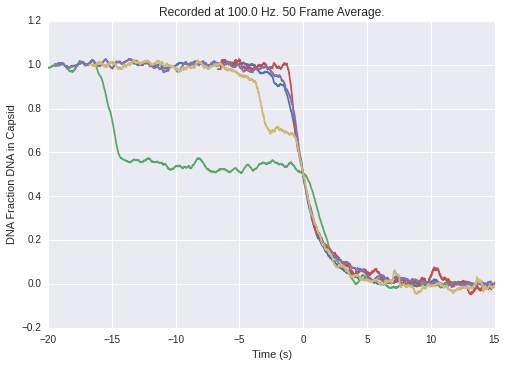

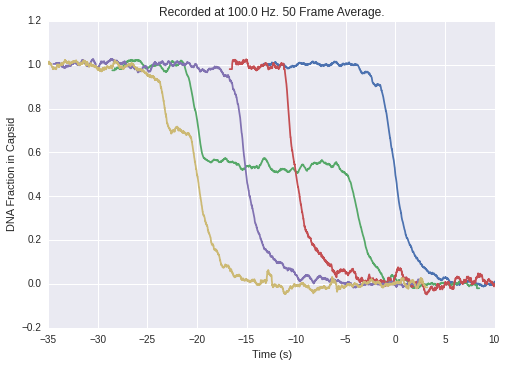

In [2]:
#plot fraction ejected vs. time
plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(datas)):
    data = datas[i]
    time = times[:data.shape[0]] - index_offset[i]*time_spacing
    plt.plot(time,helpers.movingaverage1D(data,n_mov_avg), '-',label = str(i))
plt.xlabel('Time (s)')
plt.ylabel('DNA Fraction DNA in Capsid')
plt.xlim([-20,15])


plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(datas)):
    data = datas[i]
    time = times[:data.shape[0]] - index_offset[i]*time_spacing - step_offset*i
    plt.plot(time,helpers.movingaverage1D(data,n_mov_avg),'-', label = filelist[i])
plt.xlabel('Time (s)')
plt.ylabel('DNA Fraction in Capsid')
plt.xlim([-35,10])

# Remove pauses

(-35, 10)

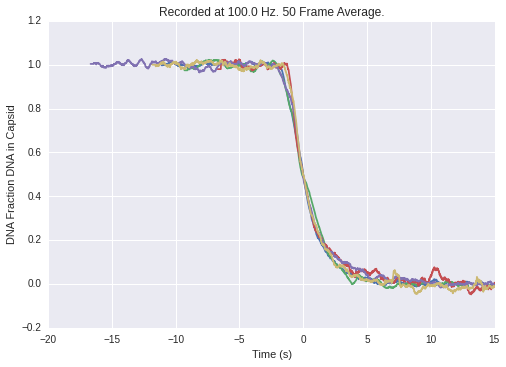

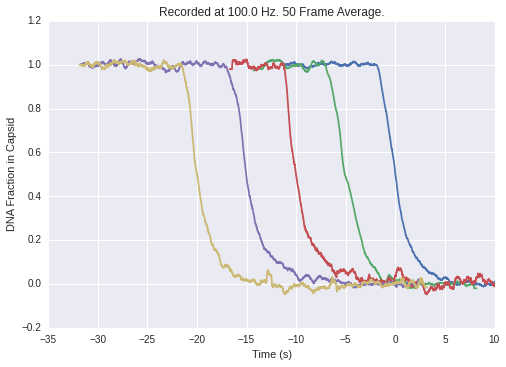

In [3]:
pauses = []
for i in range(len(params)):
    pauses.append(params[i]['pauses'])
datas = helpers.RemovePauses(datas,pauses)

#get time offset to align each
index_offset = []
for data in datas:   
    index_offset.append( abs(helpers.movingaverage1D(data,100)-t_offset_point).argmin()  )

#print(len(datas[0]))

#plot fraction ejected vs. time
plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(datas)):
    data = datas[i]
    time = times[:data.shape[0]] - index_offset[i]*time_spacing
    plt.plot(time,helpers.movingaverage1D(data,n_mov_avg), '-',label = str(i))
plt.xlabel('Time (s)')
plt.ylabel('DNA Fraction DNA in Capsid')
plt.xlim([-20,15])


plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(datas)):
    data = datas[i]
    time = times[:data.shape[0]] - index_offset[i]*time_spacing - step_offset*i
    plt.plot(time,helpers.movingaverage1D(data,n_mov_avg),'-', label = filelist[i])
plt.xlabel('Time (s)')
plt.ylabel('DNA Fraction in Capsid')
plt.xlim([-35,10])

# Take derivative

(-20, 15)

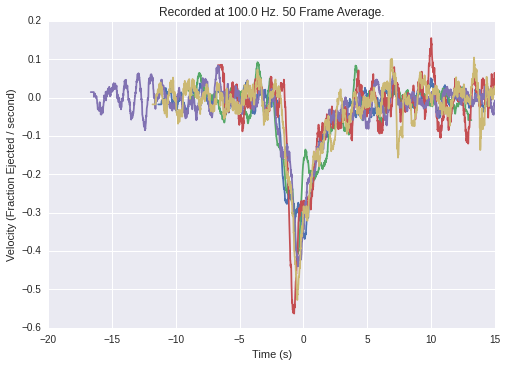

In [4]:
#Take derivative and plot ejection velocity vs. time.
vels = []
for data in datas:
    vels.append( td.diffDerivative(data,n_mov_avg)/time_spacing )


#plot derivative
plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(vels)):
    data = datas[i]
    time = times[:data.shape[0]-1] - index_offset[i]*time_spacing
    plt.plot(time,vels[i],'-', label = str(i))
plt.xlabel('Time (s)')
plt.ylabel('Velocity (Fraction Ejected / second)')
plt.xlim([-20,15])    

# Bin data based on Fraction Ejected

/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


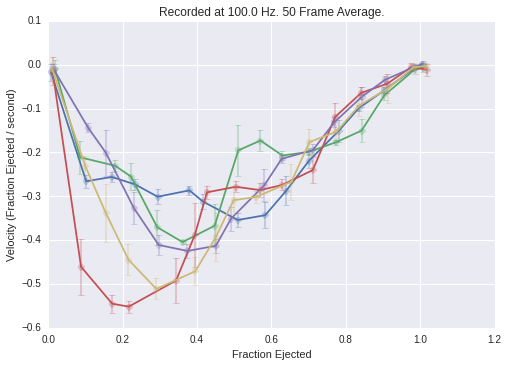

In [5]:
n_bins = 15

bins = np.arange(0,n_bins+1)/float(n_bins)
binned_datas = []
binned_vels = []
binned_datas_mean = np.empty((len(datas), n_bins+1 ))
binned_vels_mean = np.empty((len(datas), n_bins+1 ))
binned_datas_std = np.empty((len(datas), n_bins+1 ))
binned_vels_std = np.empty((len(datas), n_bins+1 ))
binned_datas_n = np.empty((len(datas), n_bins+1 ))



for i in range(0,len(datas)):
    bin_index = np.digitize( helpers.movingaverage1D(datas[i], n_mov_avg), bins) # git bin for each value
    
    #get all values in each bin
    binned_data = []
    binned_vel = []
    binned_vel_mean = np.empty(n_bins)
    binned_data_mean = np.empty(n_bins)
    for j in range(0,n_bins+1):
        #get raw data
        binned_data.append(datas[i][bin_index == j] )
        binned_vel.append(vels[i][bin_index[:-1] == j] )

        #get mean and std data
        binned_datas_mean[i,j] = binned_data[-1].mean()
        binned_vels_mean[i,j] = binned_vel[-1].mean()
        binned_datas_std[i,j] = binned_data[-1].std()
        binned_vels_std[i,j] = binned_vel[-1].std()
        binned_datas_n[i,j] = len(binned_data[-1])
        
    binned_datas.append(binned_data)
    binned_vels.append(binned_vel)
    
#plot velocity
colors = seaborn.color_palette("deep", 10)
plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(binned_vels)):
    plt.plot(1-binned_datas_mean[i,:], binned_vels_mean[i,:], '-', label = str(i), color = colors[i])
    y_errorbar = binned_vels_std[i,:]/np.sqrt( binned_datas_n[i,:]/float(n_mov_avg) )
    x_errorbar = binned_datas_std[i,:]/np.sqrt( binned_datas_n[i,:]/float(n_mov_avg))  
    plt.errorbar(1-binned_datas_mean[i,:], binned_vels_mean[i,:], yerr=y_errorbar, fmt = 'o', capthick = 1, alpha = 0.3, color = colors[i])
    #plt.errorbar(binned_datas_mean[i,:], binned_vels_mean[i,:], xerr = x_errorbar, yerr=y_errorbar, fmt = 'o', capthick = 1, alpha = 0.3, color = colors[i])
plt.xlabel('Fraction Ejected')
plt.ylabel('Velocity (Fraction Ejected / second)')
#plt.savefig('/home/agoldfain/forRees.eps', dpi=300)


# Convert Velocity to a Friction

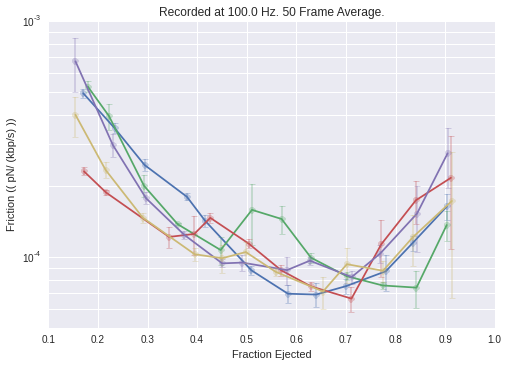

In [6]:
F0 = 55000. #pN/nm^2
c = .27 #nm
Rout = 29. # nm
z = 2*Rout # nm
L_max = 48500*.34 #nm
psi_p = 50. # nm
kBT = 1.38e-23*(273.15+24) *1e12*1e9 # convert to pN and nm
binned_forces = np.empty((len(datas), n_bins+1 ))
for i in range(0,len(datas)):
    binned_forces[i,:] = ef.ejection_force(binned_datas_mean[i,:]*L_max,F0,c,Rout,z,psi_p,kBT,geom = 'cyl')
        
binned_frictions_mean = binned_forces/(binned_vels_mean*L_max)*-1
binned_frictions_std = binned_forces*binned_vels_std/binned_vels_mean**2/L_max

#plot friction
colors = seaborn.color_palette("deep", 10)
plt.figure();plt.title( 'Recorded at ' + str(1/time_spacing) + ' Hz. ' +str(n_mov_avg) + ' Frame Average.' )
for i in range(0,len(binned_vels)):
    x_vals = 1-binned_datas_mean[i,:][2:-2]
    y_vals = binned_frictions_mean[i,:][2:-2]
    plt.plot(x_vals, y_vals, '-', label = str(i), color = colors[i])
    y_errorbar = (binned_frictions_std[i,:]/np.sqrt( binned_datas_n[i,:]/float(n_mov_avg) ))[2:-2]
    x_errorbar = (binned_datas_std[i,:]/np.sqrt( binned_datas_n[i,:]/float(n_mov_avg) ))[2:-2]
    plt.errorbar(x_vals, y_vals, yerr=y_errorbar, fmt = 'o', capthick = 1, alpha = 0.3, color = colors[i])
    #plt.errorbar(x_vals, y_vals, xerr = x_errorbar, yerr=y_errorbar, fmt = 'o', capthick = 1, alpha = 0.3, color = colors[i])
plt.xlabel('Fraction Ejected')
plt.ylabel('Friction (( pN/ (kbp/s) ))')
plt.yscale('log')
plt.ylim(5e-5,1e-3)
#plt.savefig('/home/agoldfain/forRees2.eps', dpi=300)


In [7]:
bins[1:-1]

array([ 0.06666667,  0.13333333,  0.2       ,  0.26666667,  0.33333333,
        0.4       ,  0.46666667,  0.53333333,  0.6       ,  0.66666667,
        0.73333333,  0.8       ,  0.86666667,  0.93333333])